# Demonstration of MCE IRL code & environments

This is just tabular environments & vanilla MCE IRL.

In [45]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import copy

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import torch as th

import imitation.algorithms.mce_irl as tirl
import imitation.envs.examples.model_envs as menv
import imitation.rewards.reward_nets as rn

sns.set(context="notebook")

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IRL on a random MDP

Testing both linear reward models & MLP reward models.

In [46]:
mdp = menv.RandomMDP(
    n_states=16,
    n_actions=3,
    branch_factor=2,
    horizon=10,
    random_obs=True,
    obs_dim=5,
    generator_seed=42,
)
V, Q, pi = tirl.mce_partition_fh(mdp)
Dt, D = tirl.mce_occupancy_measures(mdp, pi=pi)
demo_counts = D @ mdp.observation_matrix
(obs_dim,) = demo_counts.shape

In [47]:
rmodel = rn.BasicRewardNet(
    mdp.pomdp_observation_space,
    mdp.action_space,
    use_action=False,
    use_next_state=False,
    use_done=False,
    hid_sizes=[],
)
opt = th.optim.Adam(rmodel.parameters(), lr=0.1)
D_fake = tirl.MCEIRL(
    D, mdp, rmodel, optimizer_cls=th.optim.Adam, optimizer_kwargs=dict(lr=0.1),
    linf_eps=1e-1
).train()

--------------------------
| grad_norm   | 18.3     |
| iteration   | 0        |
| linf_delta  | 1.71     |
| weight_norm | 0.868    |
--------------------------


In [48]:
rmodel = rn.BasicRewardNet(
    mdp.pomdp_observation_space,
    mdp.action_space,
    use_action=False,
    use_next_state=False,
    use_done=False,
    hid_sizes=[32, 32]
)
opt = th.optim.Adam(rmodel.parameters(), lr=0.1)
D_fake = tirl.MCEIRL(
    D, mdp, rmodel, optimizer_cls=th.optim.Adam, optimizer_kwargs=dict(lr=0.1),
    linf_eps=1e-2
).train()

--------------------------
| grad_norm   | 7.48     |
| iteration   | 0        |
| linf_delta  | 1.37     |
| weight_norm | 6.08     |
--------------------------
--------------------------
| grad_norm   | 17.7     |
| iteration   | 100      |
| linf_delta  | 0.375    |
| weight_norm | 30.2     |
--------------------------
--------------------------
| grad_norm   | 1.65     |
| iteration   | 200      |
| linf_delta  | 0.0695   |
| weight_norm | 63.4     |
--------------------------
--------------------------
| grad_norm   | 6.06     |
| iteration   | 300      |
| linf_delta  | 0.0527   |
| weight_norm | 63.5     |
--------------------------


# Same thing, but on grid world

The true reward here is not linear in the reduced feature space (i.e $(x,y)$ coordinates). Finding an appropriate linear reward is impossible (as I will demonstration), but an MLP should Just Work(tm).

--------------------------
| grad_norm   | 3.89     |
| iteration   | 0        |
| linf_delta  | 2.02     |
| weight_norm | 0.626    |
--------------------------
--------------------------
| grad_norm   | 0.172    |
| iteration   | 100      |
| linf_delta  | 1.37     |
| weight_norm | 4.74     |
--------------------------
--------------------------
| grad_norm   | 0.0978   |
| iteration   | 200      |
| linf_delta  | 1.31     |
| weight_norm | 6.46     |
--------------------------
--------------------------
| grad_norm   | 0.0696   |
| iteration   | 300      |
| linf_delta  | 1.28     |
| weight_norm | 7.69     |
--------------------------
--------------------------
| grad_norm   | 0.054    |
| iteration   | 400      |
| linf_delta  | 1.26     |
| weight_norm | 8.81     |
--------------------------
--------------------------
| grad_norm   | 0.0437   |
| iteration   | 500      |
| linf_delta  | 1.25     |
| weight_norm | 9.52     |
--------------------------
--------------------------
|

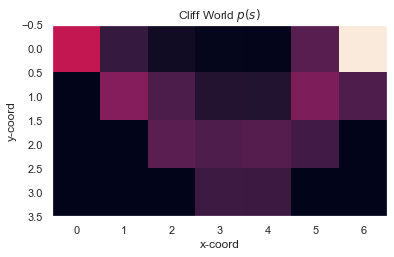

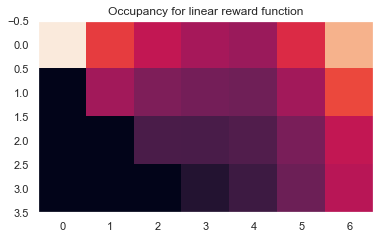

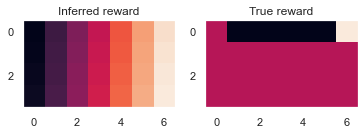

In [49]:
# Same experiments, but on grid world
mdp = menv.CliffWorld(width=7, height=4, horizon=8, use_xy_obs=True)
V, Q, pi = tirl.mce_partition_fh(mdp)
Dt, D = tirl.mce_occupancy_measures(mdp, pi=pi)
demo_counts = D @ mdp.observation_matrix
(obs_dim,) = demo_counts.shape
rmodel = rn.BasicRewardNet(
    mdp.pomdp_observation_space,
    mdp.action_space,
    use_action=False,
    use_next_state=False,
    use_done=False,
    hid_sizes=[],
)
D_fake = tirl.MCEIRL(
    D, mdp, rmodel, optimizer_cls=th.optim.Adam, optimizer_kwargs=dict(lr=0.1),
    linf_eps=0.1
).train()

mdp.draw_value_vec(D)
plt.title("Cliff World $p(s)$")
plt.xlabel("x-coord")
plt.ylabel("y-coord")
plt.show()

mdp.draw_value_vec(D_fake)
plt.title("Occupancy for linear reward function")
plt.show()
plt.subplot(1, 2, 1)
mdp.draw_value_vec(
    rmodel(th.as_tensor(mdp.observation_matrix), None, None, None).detach().numpy()
)
plt.title("Inferred reward")
plt.subplot(1, 2, 2)
mdp.draw_value_vec(mdp.reward_matrix)
plt.title("True reward")
plt.show()

--------------------------
| grad_norm   | 29.4     |
| iteration   | 0        |
| linf_delta  | 2        |
| weight_norm | 22.5     |
--------------------------
--------------------------
| grad_norm   | 0.604    |
| iteration   | 250      |
| linf_delta  | 0.315    |
| weight_norm | 24.3     |
--------------------------
--------------------------
| grad_norm   | 0.255    |
| iteration   | 500      |
| linf_delta  | 0.149    |
| weight_norm | 25.5     |
--------------------------
--------------------------
| grad_norm   | 0.138    |
| iteration   | 750      |
| linf_delta  | 0.0835   |
| weight_norm | 26.5     |
--------------------------


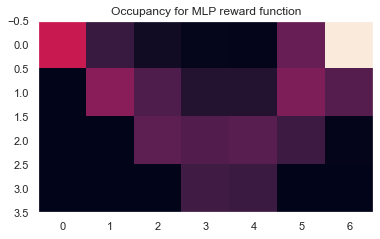

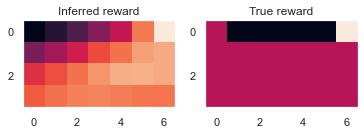

In [50]:
rmodel = rn.BasicRewardNet(
    mdp.pomdp_observation_space,
    mdp.action_space,
    use_action=False,
    use_next_state=False,
    use_done=False,
    hid_sizes=[1024],
    activation=th.nn.ReLU
)
D_fake_mlp = tirl.MCEIRL(
    D, mdp, rmodel, linf_eps=3e-2, log_interval=250,
    optimizer_cls=th.optim.Adam, optimizer_kwargs=dict(lr=1e-3),
).train()
mdp.draw_value_vec(D_fake_mlp)
plt.title("Occupancy for MLP reward function")
plt.show()
plt.subplot(1, 2, 1)
mdp.draw_value_vec(
    rmodel(th.as_tensor(mdp.observation_matrix), None, None, None).detach().numpy()
)
plt.title("Inferred reward")
plt.subplot(1, 2, 2)
mdp.draw_value_vec(mdp.reward_matrix)
plt.title("True reward")
plt.show()

In [53]:
mdp.pomdp_observation_space

Box([-inf -inf], [inf inf], (2,), float32)

Notice that the inferred reward is absolutely nothing like the true reward, but the occupancy measure still (roughly) matches the true occupancy measure.